In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/DataSets/skincancer/data/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/DataSets/skincancer/data/test")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2637
660


Found 2637 files belonging to 2 classes.


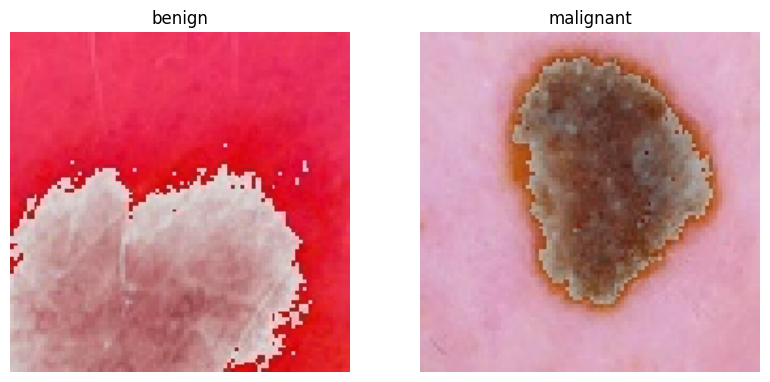

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,benign,1440
1,malignant,1197


<Axes: xlabel='No. of Image', ylabel='Class'>

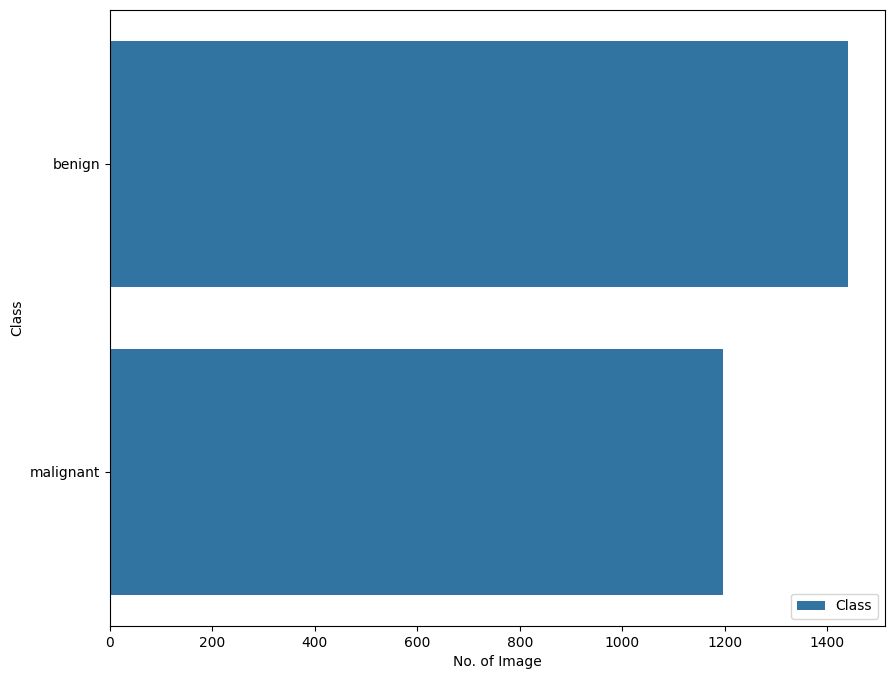

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8)  )
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [ ]:
#install Augmentor
# used for generating extra artificial images copied from dataset inorder to increase data training accur.
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/drive/MyDrive/DataSets/skincancer/data/train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

In [ ]:
#exceeding aug. cell
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


In [ ]:
#image Pre-Processing...
# Define path to input images directory
# input_dir = '/content/drive/MyDrive/DataSets/skincancer/data/train'

# Define paths to train and test directories
# train_benign = '/content/drive/MyDrive/DataSets/skincancer/data/test/benign'
# train_malignant = '/content/drive/MyDrive/DataSets/skincancer/data/test/malignant'

# # Define constants for cropping and enhancement
# crop_size = 100  # Size for cropping
# saturation_factor = 2.0  # Factor to increase saturation

# # Function to process images in a directory
# def process_images(directory):
#     # Process each image in the input directory
#     for filename in os.listdir(directory):
#         # Read the image
#         image_path = os.path.join(directory, filename)
#         image = cv2.imread(image_path)

#         if image is None:
#             print(f"Error: Unable to read image '{filename}' in directory '{directory}'")
#             continue

#         # Get dimensions of the image
#         height, width = image.shape[:2]

#         # Calculate starting and ending coordinates for cropping
#         x_start = (width - crop_size) // 2
#         y_start = (height - crop_size) // 2

#         # Check if the image is large enough for cropping
#         if x_start < 0 or y_start < 0:
#             print(f"Error: Image '{filename}' in directory '{directory}' is too small for cropping")
#             continue

#         x_end = x_start + crop_size
#         y_end = y_start + crop_size

#         # Crop the image to 100x100 pixels
#         cropped_image = image[y_start:y_end, x_start:x_end]

#         # Increase saturation
#         hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
#         hsv_image[:, :, 1] = hsv_image[:, :, 1] * saturation_factor
#         saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

#         # Overwrite the original image with the enhanced one
#         cv2.imwrite(image_path, saturated_image)  # Overwrite with enhanced image

# # Apply image processing to train directory
# process_images(train_benign)
# # Apply image processing to test directory
# process_images(train_malignant)
# Define path to the main directory containing train and test directories
main_dir = '/content/drive/MyDrive/DataSets/skincancer/data'

# Define constants for cropping and enhancement
crop_size = 100  # Size for cropping
saturation_factor = 2.0  # Factor to increase saturation

# Function to process images in a directory
def process_images(directory):
    # Process each file in the directory
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Read the image
            image_path = os.path.join(root, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Error: Unable to read image '{filename}' in directory '{root}'")
                continue

            # Get dimensions of the image
            height, width = image.shape[:2]

            # Calculate starting and ending coordinates for cropping
            x_start = (width - crop_size) // 2
            y_start = (height - crop_size) // 2

            # Check if the image is large enough for cropping
            if x_start < 0 or y_start < 0:
                print(f"Error: Image '{filename}' in directory '{root}' is too small for cropping")
                continue

            x_end = x_start + crop_size
            y_end = y_start + crop_size

            # Crop the image to 100x100 pixels
            cropped_image = image[y_start:y_end, x_start:x_end]

            # Increase saturation
            hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
            hsv_image[:, :, 1] = hsv_image[:, :, 1] * saturation_factor
            saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

            # Overwrite the original image with the enhanced one
            cv2.imwrite(image_path, saturated_image)  # Overwrite with enhanced image

# Apply image processing to train directory
process_images(os.path.join(main_dir, 'train'))

# Apply image processing to test directory
process_images(os.path.join(main_dir, 'test'))

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=64,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#USING CNN Model Architecture here*

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#forth Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='softmax'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))


#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='softmax'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

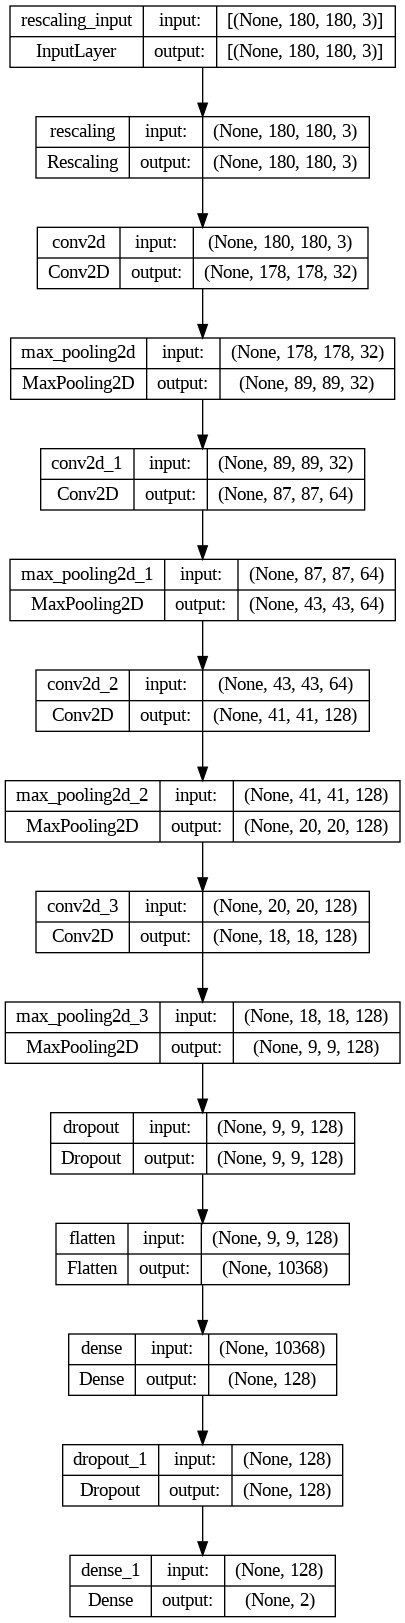

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=60,callbacks=[checkpoint,earlystop])

Epoch 1/60
33/33 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5825
Epoch 1: val_accuracy improved from 0.55408 to 0.71537, saving model to model.h5
33/33 [==============================] - 174s 5s/step - loss: 0.6735 - accuracy: 0.5825 - val_loss: 0.6535 - val_accuracy: 0.7154
Epoch 2/60
33/33 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6948
Epoch 2: val_accuracy did not improve from 0.71537
33/33 [==============================] - 183s 6s/step - loss: 0.6403 - accuracy: 0.6948 - val_loss: 0.6223 - val_accuracy: 0.7059
Epoch 3/60
33/33 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.7223
Epoch 3: val_accuracy did not improve from 0.71537
33/33 [==============================] - 164s 5s/step - loss: 0.6083 - accuracy: 0.7223 - val_loss: 0.6041 - val_accuracy: 0.7135
Epoch 4/60
33/33 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7090
Epoch 4: val_accuracy improved from 0.71537 to 0.74

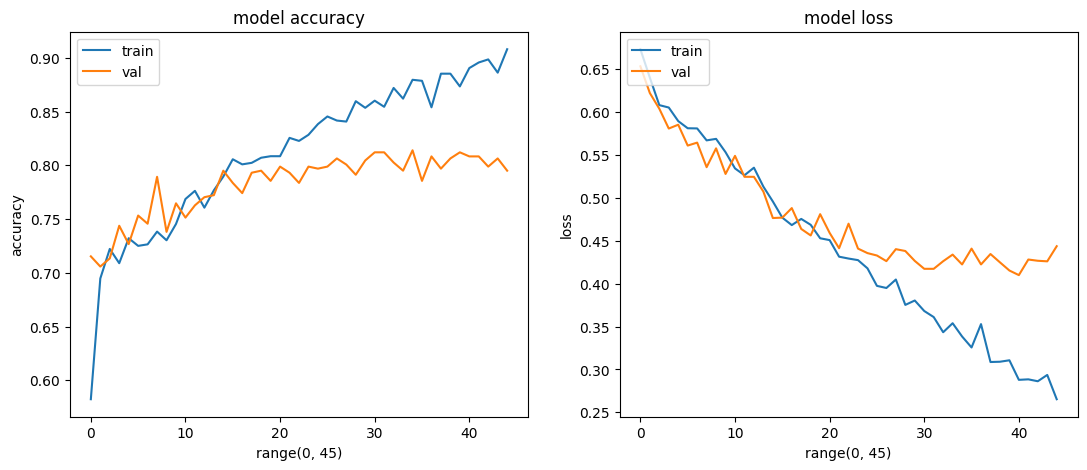

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 38ms/step
Actual Class : malignant

Predictive Class : malignant



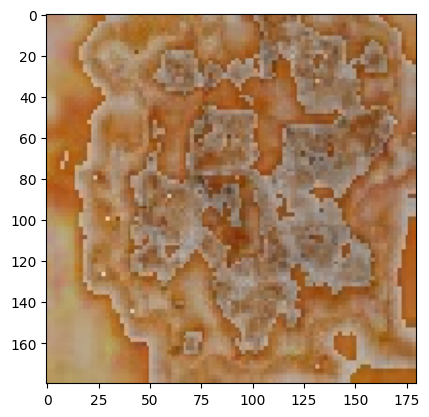

In [29]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[1] +'\n\n'+ "Predictive Class : "+pred_class +'\n' )

In [ ]:
predicted_labels = np.where(pred_class > 0, 1, 0)
actual_labels = np.where(Test_image > 0, 1, 0)


In [ ]:
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels)
f1 = f1_score(actual_labels, predicted_labels)

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
